#### ReadMe
This exercise is about Bitcoin. The data records all trades at Coinbase in March 2020. Unluckily, we only see market price and quantity traded. But the data gives the indicator of “BUY” or “SELL” on the taker side. This indicator is not available for most of equity trades dataset.

#### Questions: 

* Calculate Kyle’s lambda (market impact) for all the data in March
* Calculate Kyle’s lambda (market impact), volume, signed volume, volume-weighted price by day and hour
* Plot constructed variables in the previous bullet point 
* What patterns do you see? Make some comments
* Is there momentum in Bitcoin returns?
* Can you ﬁgure out good predictor variables for returns?
* Construct a trading strategy based on your analysis
* Plot the performance of the trading strategy 



#### Import the relevant modules

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np
import yfinance as yf
import requests
from math import sqrt
import matplotlib.pyplot as plt
import datatable as dt
from datatable import dt, f, by, g, join, sort, update, ifelse
import os 
import math
from datetime import datetime
from regpyhdfe import Regpyhdfe


In [2]:
# Read in all files in the folder (note that some files have difference sizes)
data_folder = '/Users/yiyujie/Desktop/program/Trading, Market Frictions, and FinTech/BTC_coinbase_trades'
data = pd.DataFrame()
for subdir, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith('.gz'):
            file_path = os.path.join(subdir, file)
            df = pd.read_csv(file_path, compression='gzip', sep=';')
            df= df[['time_exchange', 'price', 'base_amount','taker_side']]
            data = pd.concat([data, df], ignore_index=True)

In [94]:
# Assign trading side
data['sign'] = data['taker_side'].apply(lambda x: 1 if x == 'BUY' else -1)
# Calculate trading signed trading volume (buy - sell)
data['signed_trading_volume'] = data['sign'] * data['base_amount']# * data['price']
# Calcuate return
data['return'] = data['price'].pct_change().fillna(0) # -1

#### Calculate price impact 
Note that price impact means price movement due to $\$1$ of trade of 1 share of trade
Question, why is it better to define price impact using $\Delta p/\$$ of trader than $\Delta p$/share of trade? 

##### Overall price impact

In [95]:
from sklearn.linear_model import LinearRegression
X = data['signed_trading_volume'].values.reshape(-1, 1)
y = data['return'].values
model = LinearRegression()
model.fit(X, y).coef_

array([4.1242099e-05])

##### Price impact by hour
This requires to first aggregate data to data/hour level 

In [96]:
hour_lambda = data.resample('h').apply(lambda x : model.fit(x['signed_trading_volume'].values.reshape(-1, 1),x['return'].values).coef_[0])
day_lambda = data.resample('d').apply(lambda x : model.fit(x['signed_trading_volume'].values.reshape(-1, 1),x['return'].values).coef_[0])

##### Plot

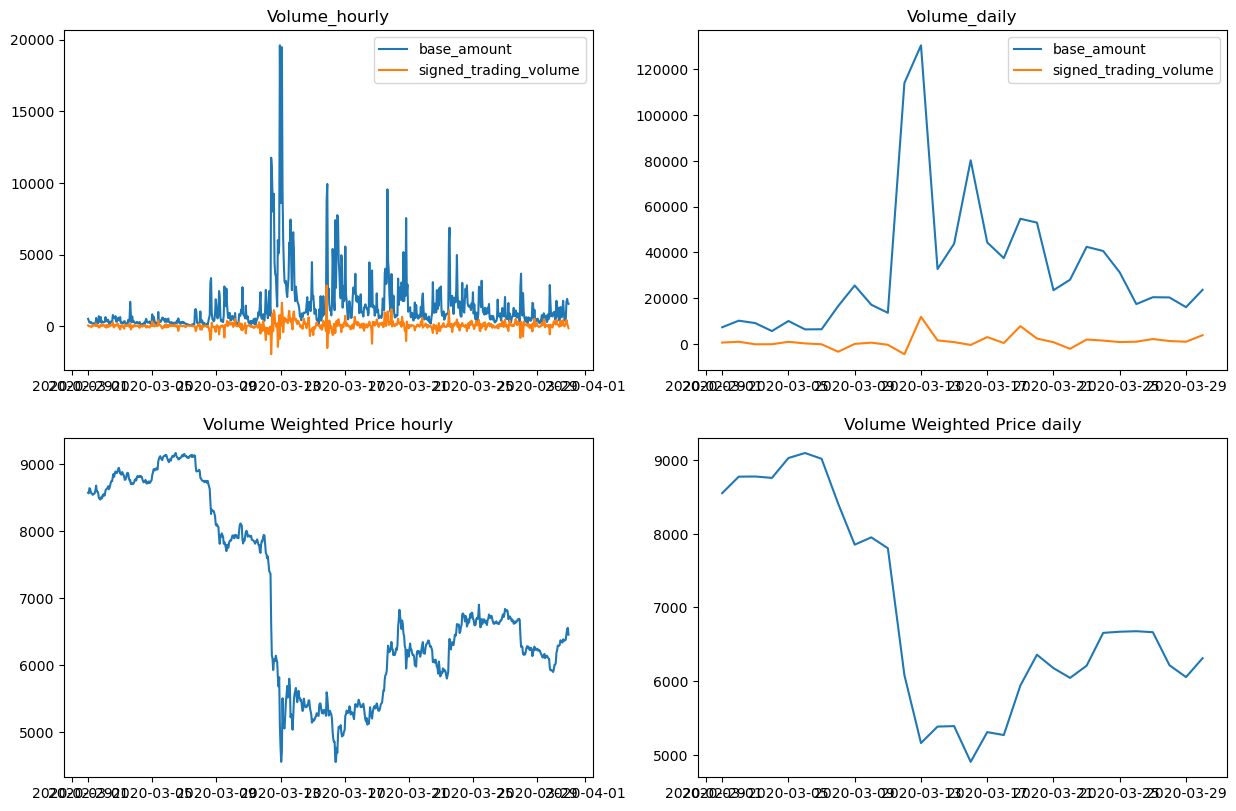

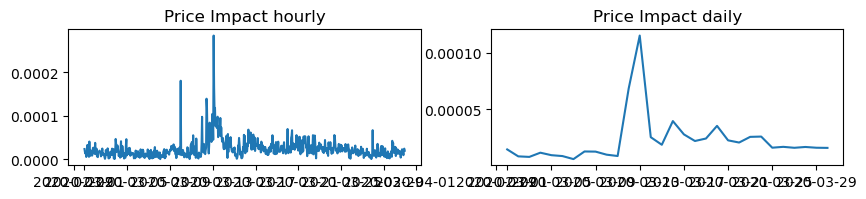

In [104]:
plt.figure(figsize=(15, 15))
plt.subplot(3, 2, 1)
plt.title('Volume_hourly')
plt.plot(data['base_amount'].resample('h').sum(),label='base_amount')
plt.plot(data['signed_trading_volume'].resample('h').sum(),label='signed_trading_volume')
plt.legend()
plt.subplot(3, 2, 2)
plt.title('Volume_daily')
plt.plot(data['base_amount'].resample('d').sum(),label='base_amount')
plt.plot(data['signed_trading_volume'].resample('d').sum(),label='signed_trading_volume')
plt.legend()
plt.subplot(3, 2, 3)
plt.title('Volume Weighted Price hourly')
plt.plot((data['price'] * data['base_amount']).resample('h').sum() / data['base_amount'].resample('h').sum())
plt.subplot(3, 2, 4)
plt.title('Volume Weighted Price daily')
plt.plot((data['price'] * data['base_amount']).resample('d').sum() / data['base_amount'].resample('d').sum())
#plt.plot((data['price'] * data['signed_trading_volume']).resample('d').sum() / data['signed_trading_volume'].resample('d').sum())
plt.figure(figsize=(10, 6))
plt.subplot(3, 2, 5)
plt.title('Price Impact hourly')
plt.plot(hour_lambda)
plt.subplot(3, 2, 6)
plt.title('Price Impact daily')
plt.plot(day_lambda)

* We can see that when the volume rise up, price will rise up and price impact will rise up.

##### Forecasting Power of lambda
Try signed lambda 


In [84]:
hour_sign = [1 if i > 0 else -1 for i in data['signed_trading_volume'].resample('h').sum()]
hour_signed_lambda = hour_lambda * hour_sign
day_sign = [1 if i > 0 else -1 for i in data['signed_trading_volume'].resample('d').sum()]
day_signed_lambda = day_lambda * day_sign

Text(0, 0.5, 'hour_price_change')

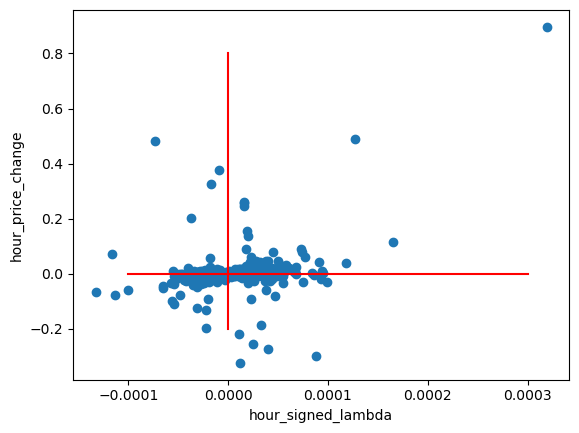

In [101]:
plt.scatter(hour_signed_lambda,hour_price_change)
plt.plot([-0.0001,0.0003],[0,0],'r')
plt.plot([0,0],[-0.2,0.8],'r')
plt.xlabel('hour_signed_lambda')
plt.ylabel('hour_price_change')

#### Trading Strategy based on Signed lambda

* We buy when hour_signed_lambda is positive and sell when hour_signed_lambda is negative.

/var/folders/l_/m6g3497s5j77bqb9jr7506tc0000gn/T/ipykernel_24556/3329687672.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hour_price_change = data['return'].resample('h').apply(lambda x : np.cumprod(x+1)[-1])


Text(0, 0.5, 'cummulative return')

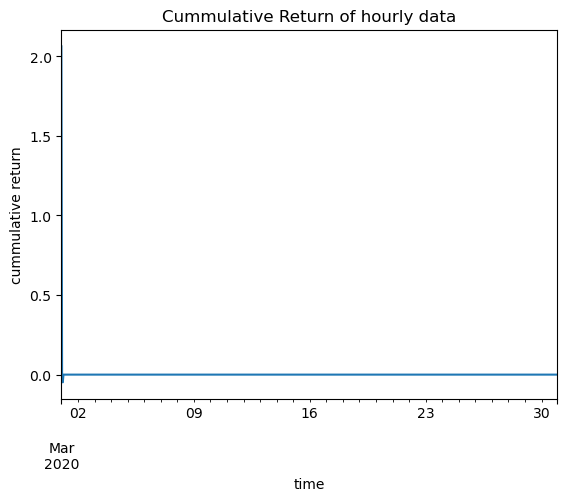

In [111]:
hour_price_change = data['return'].resample('h').apply(lambda x : np.cumprod(x+1)[-1])
np.cumprod((hour_signed_lambda>0) * hour_price_change - (hour_signed_lambda<0) * hour_price_change + 1).plot()
plt.title('Cummulative Return of hourly data')
plt.xlabel('time')
plt.ylabel('cummulative return')